PROBLEMATIQUE DE NOTRE ETUDE:
# “How can the European bank identify and predict key factors driving customer churn, and what strategies can be implemented to reduce churn based on customer profiles and behavior patterns?”

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
df_full = pd.read_csv("churn_bank.csv") # if already in the repo, otherwise use the full path

As we saw previously (in the first part) around 20% of the customers have exited the bank. In the following part we try to identify and predict key factors driving customers churn. In this way banks can possibly reduce this number based on customer profiles and behavior patterns. 

# Correlation Analysis

Global view. Let's build a correlation matrix to get a first idea of what might affect churn

[Text(0.5, 1.0, 'Overview: Correlation matrix')]

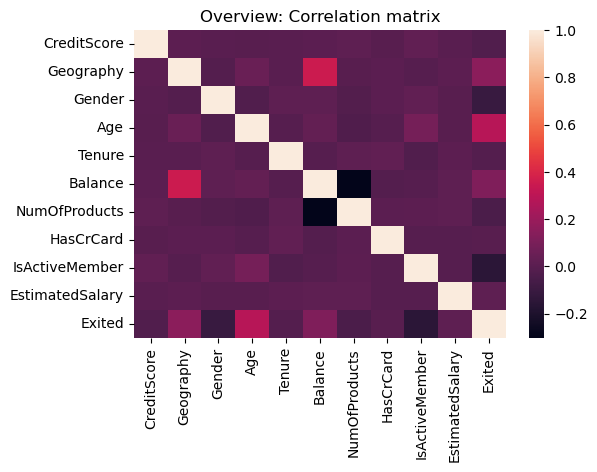

In [4]:
# correlation matrix only takes numerical values not string. 
# therefore we transform the Geography and Gender as numerical values (dummies).
COUNTRY = {"France":"1",
        "Spain":"2",
        "Germany":"3"}
GENDER = {"Female":"1",
        "Male":"2"}

df_corr = df_full.copy()
df_corr.replace({'Geography': COUNTRY, 'Gender': GENDER}, inplace=True) 

df_corr = df_corr.drop(columns=["Surname", "CustomerId"])
# computing it
matrix_corr = df_corr.corr()
# plotting
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(matrix_corr)
# title and axis labels
ax.set(
    title="Overview: Correlation matrix"
)

# save the figs for after - plt.savefig('CorrelationMatrix_1.png')

Strongest correlation

- Geography - Exited. Ok maybe they churn more a certain country easy to check. 
- Age - Exited. 
- Balance - Exited 
   
- Balance - Geography (something to look at in part 1 with maybe Germany VS the other countries. 
Maybe the balance = 0 est concentré plus dans un pays que dans les autres)
- Nbr of products - Exited (mais very little et ça peut être du au très faible nombre de customer avec 3 ou 4 products)
- Age - Is active member (very little aussi mais à check) 

### Customer profile: Geography, Age and Gender

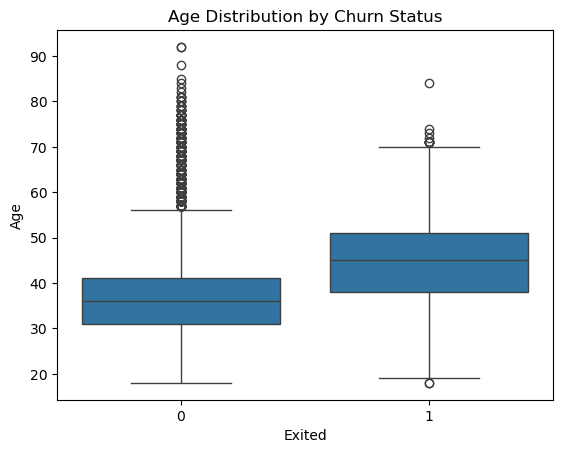

In [5]:
# 1. How does Age interactw with churn ? 

sns.boxplot(x='Exited', y='Age', data=df_full) 
plt.title('Age Distribution by Churn Status') 
plt.show()

- Seems like Customers who churned are generally older, with the median age being higher compared to non-churned customers. 
- The Interquartile Range (25th percentile - 75th percentile) seem larger for churned customers: more variability in their ages compared to non-churned customers. [not churn : most ages fall between roughly 30 and 45. churned : most ages are between approximately 45 and 60.]
- A lot of outliers for the non-churned one at older age. Some older customers stayed, they are not representative of the typical customer who did not churn?
- Customers who did not churn have a more concentrated age range (roughly 20 to 55), while customers who churned have a wider range, spreading from about 20 to 70 et plus.

Overall : older customers appear more likely to churn (comme on le voit avec the higher median age and the wider age distribution in the churned group). + Non-churned customers are generally younger, with a more concentrated age range, suggesting that the bank may be more successful in retaining younger clients.

/var/folders/rz/f98wb9gj7vz0bnm2ntxmyv3m0000gn/T/ipykernel_66552/1599937105.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rate_by_age = df_full.groupby('Age_group')['Exited'].mean()


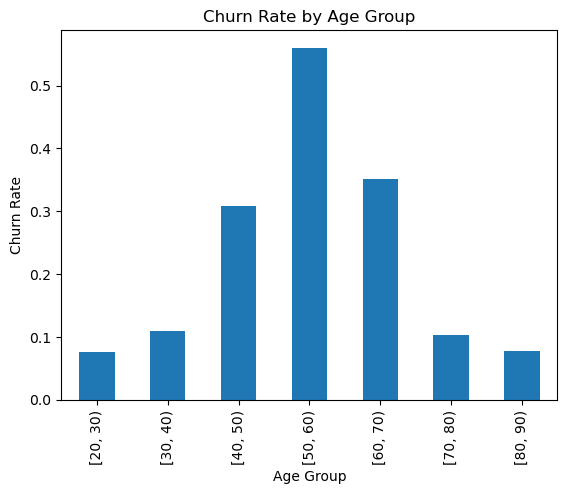

In [6]:
# OK but these results might be driven by the age distribution in the dataset.
# We need to control for the fact that in the overall dataset we have way more younger people, big concentration of people between 25 and 45 years old.
# Create age groups (e.g., bin ages into 10-year intervals)

df_full['Age_group'] = pd.cut(df_full['Age'], bins=[20, 30, 40, 50, 60, 70, 80, 90], right=False) 
# Calculate churn rate per age group 
churn_rate_by_age = df_full.groupby('Age_group')['Exited'].mean() 
churn_rate_by_age.plot(kind='bar') 
plt.title('Churn Rate by Age Group') 
plt.ylabel('Churn Rate') 
plt.xlabel('Age Group') 
plt.show()


In [7]:
## this part is more prediction - logisitc regression model

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 

X = df_full[['Age']] 
y = df_full['Exited'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

model = LogisticRegression() 
model.fit(X_train, y_train) 

# show how much age influences churn
print(f"Coefficient for Age: {model.coef_[0][0]}")

Coefficient for Age: 0.06274384470379325


Holding all else constant, for every 1 year increase in age, the (log?)odds of a customer churning increases by almost 6.5% (cause log) - in lign with the above results showing that older customers are more likely to churn. 

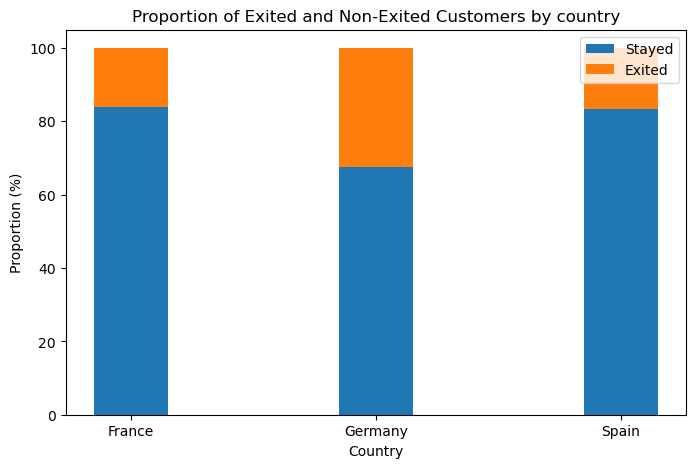

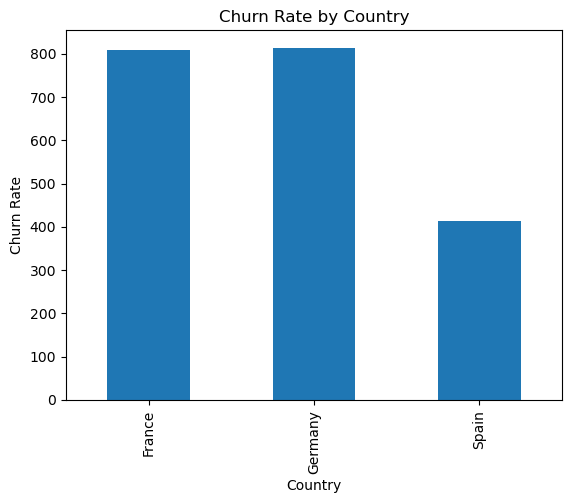

In [40]:
# 2. How does Geography interacts with churn ? 
    # in relative terms, relative comparison : 
df_geo_exit = (df_full
      .groupby("Geography")["Exited"]
      .value_counts(normalize=True)
      .mul(100)
      .round(2)
      .unstack())

fig, ax = plt.subplots(figsize = (8,5))

ax.bar(df_geo_exit.index, df_geo_exit[0], label = 'Stayed', width = 0.3) 
ax.bar(df_geo_exit.index, df_geo_exit[1], bottom = df_geo_exit[0], label='Exited', width = 0.3)

ax.set(
    title = "Proportion of Exited and Non-Exited Customers by country",
    xlabel = "Country",
    ylabel = "Proportion (%)"
)
ax.legend()
plt.show()

    # in absolute count, total number of customers who exited : 
df_full[df_full['Exited'] == 1].groupby('Geography')['Exited'].count().plot(kind='bar') 
plt.title('Churn Rate by Country') 
plt.ylabel('Churn Rate') 
plt.xlabel('Country') 
plt.show()



ATTENTION A L'INTERPRETATION 

First chart: gives a relative comparison WITHIN each country. within germany the proportion of customers exiting is higher relative to the total population 
Second chart: gives an absolute count of customers who churned in each country. In fine same number fo customer leave in france and germany. 

En soit c'est la relative proportion qui est intéressante pour comprendre pourquoi en germany c'est comme ça mais les deux sont utiles à l'analyse. 

### Financial Analysis 

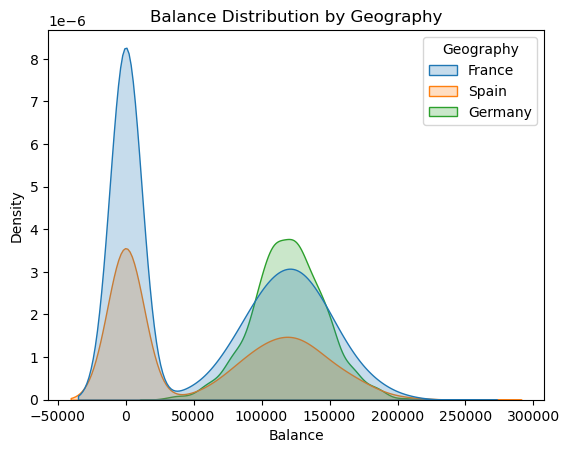

In [41]:
# Quick look how does Balance interact with Geography - and therefore after how is it interacting with churn ?

sns.kdeplot(data=df_full, x="Balance", hue="Geography", fill=True) 
plt.title('Balance Distribution by Geography') 
plt.xlabel('Balance') 
plt.ylabel('Density') 
plt.show() 

# CHECK - for negative balance
# xx = df_full.loc[df_full['Balance'] < 0]

The proportion of people whose balance is at 0 are mostly in France. Ce qui peut être pertinent du coup c'est de regarder si pour les balance à 0 en France on a bcp de churn relativement au reste et faire pareil pour les autres pays. Donc next will focus on the customers with a balance of 0. 

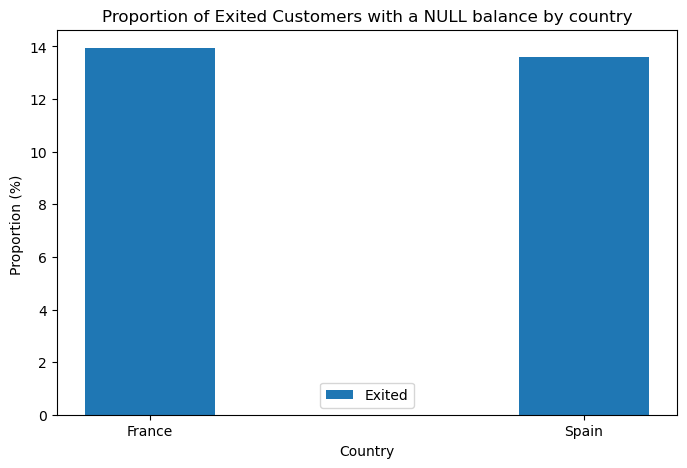

Empty DataFrame
Columns: [CustomerId, Surname, CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Exited, Age_group, SalaryBin]
Index: []


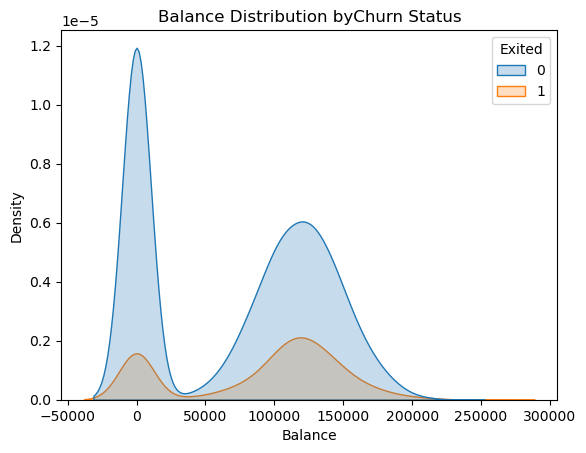

In [42]:
# relative comparison : 
df_balance_null = df_full.loc[df_full['Balance']== 0]
df_geo_exit = (df_balance_null
      .groupby("Geography")["Exited"]
      .value_counts(normalize=True)
      .mul(100)
      .round(2)
      .unstack())

fig, ax = plt.subplots(figsize = (8,5))

ax.bar(df_geo_exit.index, df_geo_exit[1], label='Exited', width = 0.3)

ax.set(
    title = "Proportion of Exited Customers with a NULL balance by country",
    xlabel = "Country",
    ylabel = "Proportion (%) "
)
ax.legend()
plt.show()
# here on display the PERCENTAGE of customers with a balance of 0 who have exited, by country.
# ok 14% de tous les customers en France et same for Spain - pas énorme

# CHECKING for absence of customers with balance = 0 in germany :
check_germ = df_full.loc[(df_full['Geography']== "Germany") & (df_full['Balance'] == 0)]
print(check_germ) #empty dataframe. No null balance at all in germany - empty dataframe


# other option visual 
sns.kdeplot(data=df_full, x="Balance", hue="Exited", fill=True) 
plt.title('Balance Distribution byChurn Status') 
plt.xlabel('Balance') 
plt.ylabel('Density') 
plt.show() 
# on voit bien que ce qui exist sont pas forcement fortement concentré sur balance = 0 
# au contraire


est-ce qu'on peut dire que the balance doesn't really predict the churning - sauf si on dit que higher balance = higher probabaility of churning ? à voir ce que ça veut dire. Maybe if it's a small bank, the richer your are the most likely your are to leave for a bigger bank? ce qui pourrait expliquer que y a bcp d'exit en allemagne là où y a pas de balance nulle ? idk 

on peut vite faire confirmer cette idée en regardant how all this interacts with the estimated salary: 

/var/folders/rz/f98wb9gj7vz0bnm2ntxmyv3m0000gn/T/ipykernel_66552/672935128.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_salary_exit = df_full.groupby("SalaryBin")["Exited"].agg(['mean'])


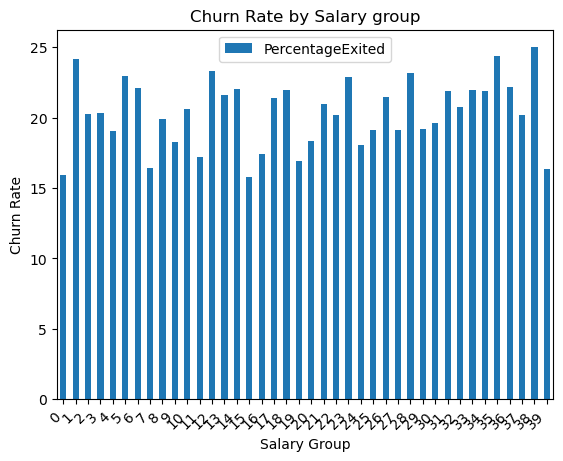

In [60]:
# we saw in part 1 that the salary distribution is quite uniform overall. 
# How does it interacts with churn? 
# pour changer un peu des graphiques let's built another dataframe 
# on y display the percentage of people that exit par intervalle de salaires 
# using salary bins 

intervals = range(0, int(df_full["EstimatedSalary"].max()) + 5000, 5000)
# let's take every 500 euros pour les intervalles
df_full["SalaryBin"] = pd.cut(df_full["EstimatedSalary"], bins=intervals, right=False)
# on créé une nouvelle colonne 

df_salary_exit = df_full.groupby("SalaryBin")["Exited"].agg(['mean'])
df_salary_exit["PercentageExited"] = df_salary_exit["mean"] * 100 #je le fais en deux fois cause not sure about the mul here
df_salary_exit = df_salary_exit.drop(columns=["mean"]).reset_index()
df_salary_exit

# on peut le plot pour voir: 
df_salary_exit.plot(kind='bar') 
plt.title('Churn Rate by Salary group') 
plt.ylabel('Churn Rate') 
plt.xlabel('Salary Group') 
plt.xticks(rotation=45, ha='right')
plt.show()


# CHECK to see if the SalaryBin intervals were well constructed 
xx = df_full[["EstimatedSalary", "SalaryBin"]] # OK good

Pas vrmt de résultat significatif. Il y ac certaines hausse du nombre d'exit sur certains intervalles de salaires mais c'est très random overall (bottom mais aussi top of the salary distribution)
On peut regarder par pays.

/var/folders/rz/f98wb9gj7vz0bnm2ntxmyv3m0000gn/T/ipykernel_66552/3516232741.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_germany["SalaryBin"] = pd.cut(df_germany["EstimatedSalary"], bins=intervals, right=False)
/var/folders/rz/f98wb9gj7vz0bnm2ntxmyv3m0000gn/T/ipykernel_66552/3516232741.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_salary_exit = df_germany.groupby("SalaryBin")["Exited"].agg(['mean'])


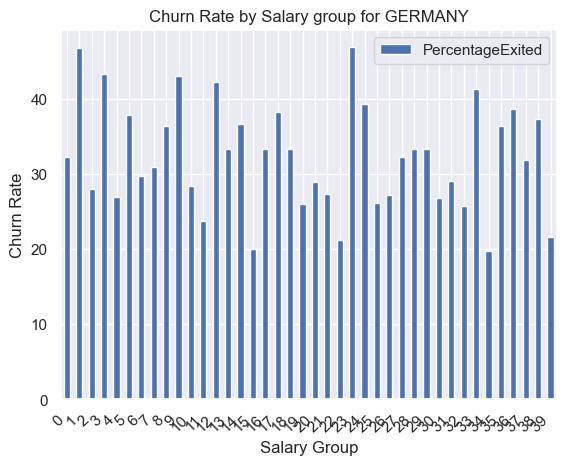

In [69]:
# Let's focus on Germany
df_germany = df_full.loc[df_full["Geography"]== "Germany"]

intervals = range(0, int(df_germany["EstimatedSalary"].max()) + 5000, 5000)
# let's take every 500 euros pour les intervalles
df_germany["SalaryBin"] = pd.cut(df_germany["EstimatedSalary"], bins=intervals, right=False)
# on créé une nouvelle colonne 

df_salary_exit = df_germany.groupby("SalaryBin")["Exited"].agg(['mean'])
df_salary_exit["PercentageExited"] = df_salary_exit["mean"] * 100 #je le fais en deux fois cause not sure about the mul here
df_salary_exit = df_salary_exit.drop(columns=["mean"]).reset_index()
df_salary_exit

# on peut le plot pour voir: 
df_salary_exit.plot(kind='bar') 
plt.title('Churn Rate by Salary group for GERMANY') 
plt.ylabel('Churn Rate') 
plt.xlabel('Salary Group') 
plt.xticks(rotation=45, ha='right')
plt.show()

Let's look at Credit score
- the first chart should be included in part 1 à la place du graphique en bar

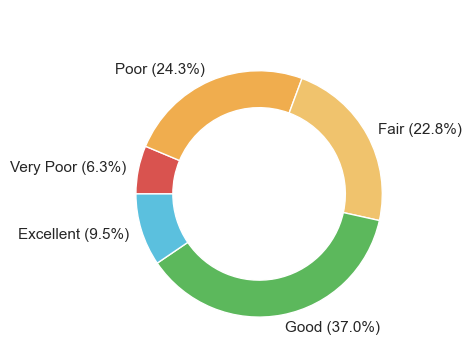

In [80]:
# first let's see if we can reproduce the chart Sofia found in google for credit score to adapt it to our data 

df_full["CreditScore"].unique()
df_full["CreditScore"].min()
df_full["CreditScore"].max()
# in our data [350 - 850]

# define the categories within the dataframe
def categorize(score):
    if score < 500:
        return 'Very Poor'
    elif score < 601:
        return 'Poor'
    elif score < 661:
        return 'Fair'
    elif score < 781:
        return 'Good'
    else:
        return 'Excellent'

df_full['Credit_Category'] = df_full['CreditScore'].apply(categorize)

# proportion of customers in each category
category_counts = df_full['Credit_Category'].value_counts(normalize=True).reindex(['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']).fillna(0)

# plot
labels = ['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']
colors = ['#d9534f', '#f0ad4e', '#f0c36d', '#5cb85c', '#5bc0de']
score_ranges = [300, 500, 601, 661, 781, 850]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Convert proportions to angles (180 degrees for half-circle)
proportions = category_counts.values
angles = proportions * 180  # Half circle is 180 degrees

ax.pie(
    proportions,
    colors=colors,
    startangle=180,
    counterclock=False,
    wedgeprops=dict(width=0.3),
    labels=[f'{label} ({p*100:.1f}%)' for label, p in zip(labels, proportions)]
)

# Adjust plot limits and hide axes
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1, 1.5])
ax.axis('off')

# Show plot
plt.show()


Pour faire un half circle reprendre ça : https://stackoverflow.com/questions/64514570/draw-semicircle-chart-using-matplotlib

/var/folders/rz/f98wb9gj7vz0bnm2ntxmyv3m0000gn/T/ipykernel_66552/2024838344.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_credit_exit['Credit_Category'] = df_credit_exit['CreditScore'].apply(categorize)


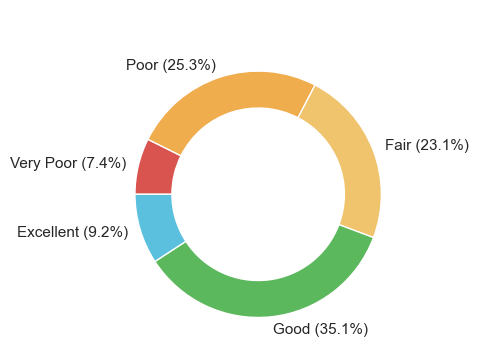

/var/folders/rz/f98wb9gj7vz0bnm2ntxmyv3m0000gn/T/ipykernel_66552/2024838344.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_credit_non_ex['Credit_Category'] = df_credit_non_ex['CreditScore'].apply(categorize)


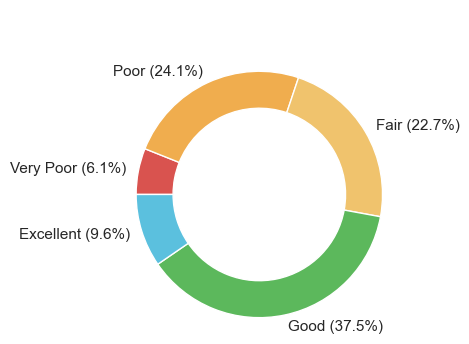

In [81]:
# How does the credit score interacts with churning? 

    # FOR EXITED
df_credit_exit = df_full.loc[df_full["Exited"]== 1]
# define the categories within the dataframe
def categorize(score):
    if score < 500:
        return 'Very Poor'
    elif score < 601:
        return 'Poor'
    elif score < 661:
        return 'Fair'
    elif score < 781:
        return 'Good'
    else:
        return 'Excellent'

df_credit_exit['Credit_Category'] = df_credit_exit['CreditScore'].apply(categorize)

# proportion of customers in each category
category_counts = df_credit_exit['Credit_Category'].value_counts(normalize=True).reindex(['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']).fillna(0)

# plot
labels = ['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']
colors = ['#d9534f', '#f0ad4e', '#f0c36d', '#5cb85c', '#5bc0de']
score_ranges = [300, 500, 601, 661, 781, 850]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Convert proportions to angles (180 degrees for half-circle)
proportions = category_counts.values
angles = proportions * 180  # Half circle is 180 degrees

ax.pie(
    proportions,
    colors=colors,
    startangle=180,
    counterclock=False,
    wedgeprops=dict(width=0.3),
    labels=[f'{label} ({p*100:.1f}%)' for label, p in zip(labels, proportions)]
)

# Adjust plot limits and hide axes
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1, 1.5])
ax.axis('off')

# Show plot
plt.show()

####

    # FOR NON EXITED
df_credit_non_ex = df_full.loc[df_full["Exited"]== 0]
# define the categories within the dataframe
def categorize(score):
    if score < 500:
        return 'Very Poor'
    elif score < 601:
        return 'Poor'
    elif score < 661:
        return 'Fair'
    elif score < 781:
        return 'Good'
    else:
        return 'Excellent'

df_credit_non_ex['Credit_Category'] = df_credit_non_ex['CreditScore'].apply(categorize)

# proportion of customers in each category
category_counts = df_credit_non_ex['Credit_Category'].value_counts(normalize=True).reindex(['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']).fillna(0)

# plot
labels = ['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']
colors = ['#d9534f', '#f0ad4e', '#f0c36d', '#5cb85c', '#5bc0de']
score_ranges = [300, 500, 601, 661, 781, 850]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Convert proportions to angles (180 degrees for half-circle)
proportions = category_counts.values
angles = proportions * 180  # Half circle is 180 degrees

ax.pie(
    proportions,
    colors=colors,
    startangle=180,
    counterclock=False,
    wedgeprops=dict(width=0.3),
    labels=[f'{label} ({p*100:.1f}%)' for label, p in zip(labels, proportions)]
)

# Adjust plot limits and hide axes
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1, 1.5])
ax.axis('off')

# Show plot
plt.show()

Doesn't seem like the credit score is much correlated with the churning. slightly more poor customer for exited mais vrmt petit quoi. 
### TODO: regarder par pays après avoir construit les fonctions parce que la flemme. 

### Activity analysis